# Projet Neural Network - Corporación Favorita Grocery Sales Forecasting

Brick-and-mortar grocery stores are always in a delicate dance with purchasing and sales forecasting. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leaving money on the table and customers fuming.

The problem becomes more complex as retailers add new locations with unique needs, new products, ever transitioning seasonal tastes, and unpredictable product marketing. Corporación Favorita, a large Ecuadorian-based grocery retailer, knows this all too well. They operate hundreds of supermarkets, with over 200,000 different products on their shelves.

Corporación Favorita has challenged the Kaggle community to build a model that more accurately forecasts product sales. They currently rely on subjective forecasting methods with very little data to back them up and very little automation to execute plans. They’re excited to see how machine learning could better ensure they please customers by having just enough of the right products at the right time.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random as rd
from tqdm import tqdm
import pandas as pd
import os
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import r2_score
from seasonal import *
from statsmodels.tsa.tsatools import *
from statsmodels.tsa.stattools import *
from statsmodels.tsa.tsatools import detrend
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import itertools
import time

from neural_network import neural_net_model, neural_net_model_3layers, rnn_model

Using TensorFlow backend.


In [2]:
# Refer to the py file: "processing_data.py"
from processing_data import preprocessing

# One shop forecast

## I - Imports

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/Users/louisgiron/Desktop/ENSAE - Mastère spé/Reseaux de neurones/projet_nn/processing_data.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train_small['unit_sales'] = train_small['unit_sales'].apply(lambda x:


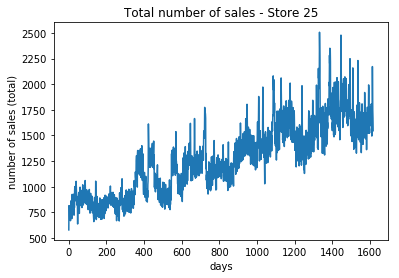

In [3]:
n = None
store_selection = 'yes'

train_all, test = preprocessing(n, store_selection)

# We are studying only one store, so the information about the city, the
# region are useless
train_all = train_all.drop(['id', 'store_nbr', 'city', 'state',
                       'cluster', 'type_x'], axis=1)
train_all = train_all.set_index('date')

In [4]:
print('Train - heads:')
print(train_all.head())
print()
print('---')
print('Train - shape:')
print(train_all.shape)

Train - heads:
            item_nbr  unit_sales onpromotion  dcoilwtico   type_y    locale  \
date                                                                          
2013-01-01    103665         7.0         NaN         NaN  Holiday  National   
2013-01-01    105574         1.0         NaN         NaN  Holiday  National   
2013-01-01    105575         2.0         NaN         NaN  Holiday  National   
2013-01-01    108079         1.0         NaN         NaN  Holiday  National   
2013-01-01    108701         1.0         NaN         NaN  Holiday  National   

           locale_name         description transferred        family  class  \
date                                                                          
2013-01-01     Ecuador  Primer dia del ano       False  BREAD/BAKERY   2712   
2013-01-01     Ecuador  Primer dia del ano       False     GROCERY I   1045   
2013-01-01     Ecuador  Primer dia del ano       False     GROCERY I   1045   
2013-01-01     Ecuador  Primer dia d

In [5]:
# Output variable
train_all.describe()

,item_nbr,unit_sales,dcoilwtico,class,perishable,transactions
count,2.057020e+06,2.057020e+06,1.385878e+06,2.057020e+06,2.057020e+06,2.052421e+06
mean,9.515877e+05,5.552518e+00,6.346885e+01,1.937001e+03,2.902072e-01,9.879964e+02
std,5.087340e+05,1.359333e+01,2.461697e+01,1.073640e+03,4.538580e-01,4.589323e+02
min,9.699500e+04,0.000000e+00,2.619000e+01,1.002000e+03,0.000000e+00,3.810000e+02
25%,5.227210e+05,1.000000e+00,4.572000e+01,1.066000e+03,0.000000e+00,7.130000e+02
50%,9.385700e+05,3.000000e+00,5.144000e+01,1.387000e+03,0.000000e+00,8.450000e+02
75%,1.313223e+06,5.946000e+00,9.334000e+01,2.652000e+03,1.000000e+00,1.046000e+03
max,2.124052e+06,2.142800e+03,1.106200e+02,7.034000e+03,1.000000e+00,3.401000e+03


In [6]:
print('Max unit sales:')
print(train_all.unit_sales.max())
print()
print('Min unit sales:')
print(train_all.unit_sales.min())
print('Moyenne unit sales:')
print(train_all.unit_sales.mean())
print()

Max unit sales:
2142.8

Min unit sales:
0.0
Moyenne unit sales:
5.552517865941992



## II - Preprocessing of the data

### A - Missing data

In [7]:
# Explore and manage the missing data
print('Before missing values management:')
print('----')
missing = train_all.apply(lambda x: x.isnull().sum(), axis=0)
missing = pd.DataFrame(missing)
missing.columns = ["Number of missing values"]

# Share of missing
missing['Share of missing'] = round(missing['Number of missing values']/len(train_all)*100,2)
print(missing)

missing_rate = {}
for col in train_all.columns:
    missing_rate[col] = np.sum(train_all[col].isna())/len(train_all[col])

missing_rate_lim = 0.7

for key in missing_rate.keys():
    if missing_rate[key] > missing_rate_lim:
        train_all = train_all.drop([key], axis=1)

    if 0 < missing_rate[key] < missing_rate_lim:
        # Handle missing values - Use the mean strategy
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp.fit(np.array(train_all[key]).reshape(-1, 1))
        temp_no_miss = imp.transform(np.array(train_all[key]).reshape(-1, 1))
        train_all[key] = temp_no_miss

print()
print('After missing values management:')
print('----')
# After the management
missing = train_all.apply(lambda x: x.isnull().sum(), axis=0)
missing = pd.DataFrame(missing)
missing.columns = ["Number of missing values"]

# Share of missing
missing['Share of missing'] = round(missing['Number of missing values']/len(train_all)*100,2)
print(missing)

Before missing values management:
----
              Number of missing values  Share of missing
item_nbr                             0              0.00
unit_sales                           0              0.00
onpromotion                     412459             20.05
dcoilwtico                      671142             32.63
type_y                         1721630             83.70
locale                         1721630             83.70
locale_name                    1721630             83.70
description                    1721630             83.70
transferred                    1721630             83.70
family                               0              0.00
class                                0              0.00
perishable                           0              0.00
transactions                      4599              0.22

After missing values management:
----
              Number of missing values  Share of missing
item_nbr                             0               0.0
unit_sales

In [8]:
print('Train - heads:')
print(train_all.head())
print()
print('---')
print('Train - shape:')
print(train_all.shape)

Train - heads:
            item_nbr  unit_sales  onpromotion  dcoilwtico        family  \
date                                                                      
2013-01-01    103665         7.0     0.069041   63.468855  BREAD/BAKERY   
2013-01-01    105574         1.0     0.069041   63.468855     GROCERY I   
2013-01-01    105575         2.0     0.069041   63.468855     GROCERY I   
2013-01-01    108079         1.0     0.069041   63.468855     GROCERY I   
2013-01-01    108701         1.0     0.069041   63.468855          DELI   

            class  perishable  transactions  
date                                         
2013-01-01   2712           1         770.0  
2013-01-01   1045           0         770.0  
2013-01-01   1045           0         770.0  
2013-01-01   1030           0         770.0  
2013-01-01   2644           1         770.0  

---
Train - shape:
(2057020, 8)


### B - Categorical Variables

In [9]:
# Categorical variables
# family is a category
family = train_all[['family', 'unit_sales']]
family = family.groupby(['family'], as_index=False)['unit_sales'].count()
family.columns = ['family', 'count']
family['repartition_percent'] = family['count']/np.sum(family['count'])*100
family = family.sort_values(by=['count'], ascending=False)
family.reset_index(inplace=True)
family = family.drop('index', axis=1)
print(family)

selection = list(family['family'].loc[:3])

# Nous gardons les 4 premieres categories (choix arbitraire) et créeons une catégorie other
def family_transform(x, selection=selection):
    if x in selection:
        return x
    else:
        return 'other'


train_all['family'] = train_all['family'].apply(family_transform)
train_all = pd.get_dummies(train_all)

print(train_all.columns)

                        family   count  repartition_percent
0                    GROCERY I  697977            33.931464
1                    BEVERAGES  302999            14.729998
2                     CLEANING  251147            12.209264
3                        DAIRY  182730             8.883239
4                      PRODUCE  130463             6.342330
5                 BREAD/BAKERY   81756             3.974487
6                PERSONAL CARE   67294             3.271431
7                         DELI   61225             2.976393
8                        MEATS   56017             2.723211
9                    HOME CARE   38835             1.887925
10                     POULTRY   33643             1.635521
11                        EGGS   32560             1.582872
12                FROZEN FOODS   30350             1.475435
13            LIQUOR,WINE,BEER   24007             1.167077
14              PREPARED FOODS   15213             0.739565
15          HOME AND KITCHEN I    7762  

### C - Data Set transformation

#### Transform the time series in handling dataset

In [10]:
def series_to_supervised(data, shift_window_past, value_to_predict, shift_window_future=0):
    """
    Input:
    -----
    data: Pandas DF
    shift_window_past: number of shifts in the past
    shift_window_future: 
    """
    name_var = data.columns
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(shift_window_past, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (name, i)) for name in name_var]
        
    # Value to predict at t
    val = data[value_to_predict]
    cols.append(val)
    names.append(str(value_to_predict) + '(t)')
    
    if shift_window_future > 0:
        # forecast sequence (t, t+1, ... t+n)
        for i in range(1, shift_window_future+1):
            cols.append(data.shift(-i))
            if i == 0:
                names += [('%s(t)' % (name)) for name in name_var]
            else:
                names += [('%s(t+%d)' % (name, i)) for name in name_var]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values (erase the first shift_window_past rows)
    agg.dropna(inplace=True)
    return agg

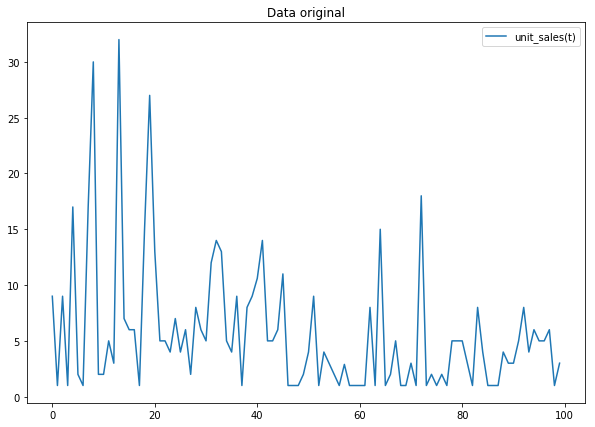

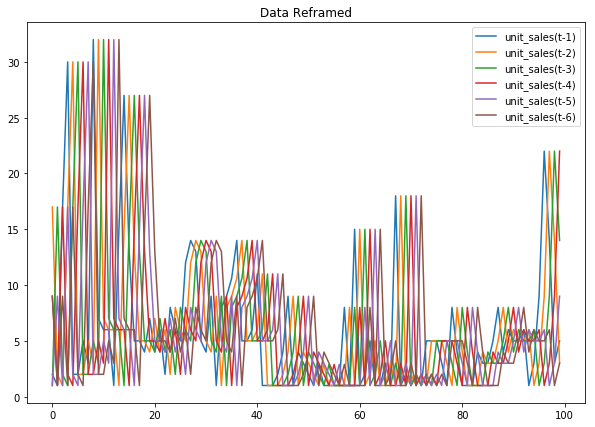

In [11]:
# load dataset
dataset = train_all.copy()

# ensure all data is float
dataset = dataset.astype('float32')

# frame as supervised learning
shift_window_past = 6
value_to_predict = 'unit_sales'
shift_window_future=0
reframed = series_to_supervised(dataset, shift_window_past, value_to_predict, shift_window_future=0)

# Visualisation
plt.figure(figsize=(10, 7))
plt.plot(list(dataset['unit_sales'])[500:600], label='unit_sales(t)')
plt.title('Data original')
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
for i in range(1, shift_window_past+1):
    plt.plot(list(reframed[('unit_sales(t-%d)' % (i))])[500:600], label=('unit_sales(t-%d)' % (i)))
plt.title('Data Reframed')
plt.legend()
plt.show()

In [12]:
reframed.head()

,item_nbr(t-6),unit_sales(t-6),onpromotion(t-6),dcoilwtico(t-6),class(t-6),perishable(t-6),transactions(t-6),family_BEVERAGES(t-6),family_CLEANING(t-6),family_DAIRY(t-6),...,dcoilwtico(t-1),class(t-1),perishable(t-1),transactions(t-1),family_BEVERAGES(t-1),family_CLEANING(t-1),family_DAIRY(t-1),family_GROCERY I(t-1),family_other(t-1),unit_sales(t)
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,103665.0,7.0,0.069041,63.468853,2712.0,1.0,770.0,0.0,0.0,0.0,...,63.468853,3044.0,0.0,770.0,0.0,1.0,0.0,0.0,0.0,1.0
2013-01-01,105574.0,1.0,0.069041,63.468853,1045.0,0.0,770.0,0.0,0.0,0.0,...,63.468853,1004.0,0.0,770.0,0.0,0.0,0.0,1.0,0.0,1.0
2013-01-01,105575.0,2.0,0.069041,63.468853,1045.0,0.0,770.0,0.0,0.0,0.0,...,63.468853,3024.0,0.0,770.0,0.0,1.0,0.0,0.0,0.0,13.0
2013-01-01,108079.0,1.0,0.069041,63.468853,1030.0,0.0,770.0,0.0,0.0,0.0,...,63.468853,1072.0,0.0,770.0,0.0,0.0,0.0,1.0,0.0,3.0
2013-01-01,108701.0,1.0,0.069041,63.468853,2644.0,1.0,770.0,0.0,0.0,0.0,...,63.468853,1004.0,0.0,770.0,0.0,0.0,0.0,1.0,0.0,1.0


In [13]:
reframed.tail()

,item_nbr(t-6),unit_sales(t-6),onpromotion(t-6),dcoilwtico(t-6),class(t-6),perishable(t-6),transactions(t-6),family_BEVERAGES(t-6),family_CLEANING(t-6),family_DAIRY(t-6),...,dcoilwtico(t-1),class(t-1),perishable(t-1),transactions(t-1),family_BEVERAGES(t-1),family_CLEANING(t-1),family_DAIRY(t-1),family_GROCERY I(t-1),family_other(t-1),unit_sales(t)
date,,,,,,,,,,,,,,,,,,,,,
2017-08-15,2089276.0,1.0,0.0,47.57,1006.0,0.0,849.0,0.0,0.0,0.0,...,47.57,1120.0,0.0,849.0,1.0,0.0,0.0,0.0,0.0,11.0
2017-08-15,2089789.0,3.0,0.0,47.57,4254.0,0.0,849.0,0.0,0.0,0.0,...,47.57,2028.0,1.0,849.0,0.0,0.0,0.0,0.0,1.0,2.0
2017-08-15,2106464.0,7.0,1.0,47.57,1148.0,0.0,849.0,1.0,0.0,0.0,...,47.57,1114.0,0.0,849.0,1.0,0.0,0.0,0.0,0.0,1.0
2017-08-15,2108569.0,1.0,0.0,47.57,1086.0,0.0,849.0,0.0,0.0,0.0,...,47.57,3040.0,0.0,849.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-08-15,2110456.0,1.0,0.0,47.57,1120.0,0.0,849.0,1.0,0.0,0.0,...,47.57,1060.0,0.0,849.0,0.0,0.0,0.0,1.0,0.0,2.0


In [14]:
print('Original set shape:')
print('----')
print(dataset.shape)
print()
print('Reframed set shape: (with shift_window = ' + str(shift_window_past) + ')')
print('----')
print(reframed.shape)

Original set shape:
----
(2057020, 12)

Reframed set shape: (with shift_window = 6)
----
(2057014, 73)


### D - Fearture importance

In [15]:
# Feature importance
X = reframed.drop(['unit_sales(t)'], axis=1).copy()
y = reframed['unit_sales(t)'].copy()

features = X.columns

print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (2057014, 72)
Shape of y: (2057014,)


In [16]:
# Model Lasso for feature selection
clf = LassoCV(cv=5)
clf = clf.fit(np.array(X), np.array(y))

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


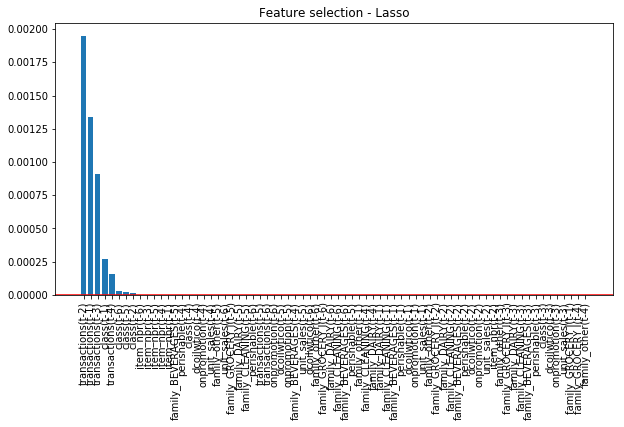

In [17]:
# Visualisation of the result
res_lasso = np.abs(clf.coef_)
index_sort = np.argsort(res_lasso)[::-1]

feature_sort = list(features[index_sort])
res_lasso_sort = res_lasso[index_sort]
treshold = 10**-6

fig = plt.figure(figsize=(10, 5))
plt.bar(np.arange(0, len(feature_sort)), res_lasso_sort)
plt.axhline(y=treshold, color='r', linestyle='-')
plt.xticks(np.arange(0, len(feature_sort)), feature_sort, rotation='vertical')
plt.title('Feature selection - Lasso')
plt.show()

In [18]:
# Treshold
treshold = 0

model = SelectFromModel(clf, threshold=treshold, prefit=True)
feature_selected_index = model.get_support(indices=True)

print('Feature selected:')
print(features[feature_selected_index])

# selection
value_to_predict = 'unit_sales(t)'
selection = list(features[feature_selected_index])
selection.append(value_to_predict)

Feature selected:
Index(['item_nbr(t-6)', 'unit_sales(t-6)', 'onpromotion(t-6)',
       'dcoilwtico(t-6)', 'class(t-6)', 'perishable(t-6)', 'transactions(t-6)',
       'family_BEVERAGES(t-6)', 'family_CLEANING(t-6)', 'family_DAIRY(t-6)',
       'family_GROCERY I(t-6)', 'family_other(t-6)', 'item_nbr(t-5)',
       'unit_sales(t-5)', 'onpromotion(t-5)', 'dcoilwtico(t-5)', 'class(t-5)',
       'perishable(t-5)', 'transactions(t-5)', 'family_BEVERAGES(t-5)',
       'family_CLEANING(t-5)', 'family_DAIRY(t-5)', 'family_GROCERY I(t-5)',
       'family_other(t-5)', 'item_nbr(t-4)', 'unit_sales(t-4)',
       'onpromotion(t-4)', 'dcoilwtico(t-4)', 'class(t-4)', 'perishable(t-4)',
       'transactions(t-4)', 'family_BEVERAGES(t-4)', 'family_CLEANING(t-4)',
       'family_DAIRY(t-4)', 'family_GROCERY I(t-4)', 'family_other(t-4)',
       'item_nbr(t-3)', 'unit_sales(t-3)', 'onpromotion(t-3)',
       'dcoilwtico(t-3)', 'class(t-3)', 'perishable(t-3)', 'transactions(t-3)',
       'family_BEVERAGES(t-

### E - Final train set

In [ ]:
train_all_processed = reframed[selection]

print('X train original shape:', reframed.shape)
print('X train processed shape:', train_all_processed.shape)

X train original shape: (2057014, 73)
X train processed shape: (2057014, 73)


## III - Training setup

In [ ]:
# Date
dates = list(train_all_processed.index)
date_unique = np.unique(dates)

In [ ]:
# Output to predict
value_to_predict = 'unit_sales(t)'

# Normalize train X
data_X = train_all_processed.drop([value_to_predict], axis=1)
data_y = train_all_processed[value_to_predict]

col_x = list(data_X.columns)
col_y = [value_to_predict]

scaler = MinMaxScaler(feature_range=(0, 1))
data_X_norm = scaler.fit_transform(data_X)
data_y_norm = scaler.fit_transform(np.array(data_y).reshape(-1, 1))

# Dataframe transformation
# X
data_X_norm = pd.DataFrame(data_X_norm)
data_X_norm.columns = col_x
data_X_norm.index = dates

# y
data_y_norm = pd.DataFrame(data_y_norm)
data_y_norm.columns = col_y
data_y_norm.index = dates

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [ ]:
# Definition of train, valid and test
train_size_ratio = 0.6
valid_train_size_ratio = 0.1
size = len(date_unique)

train_set = date_unique[np.arange(0, int(train_size_ratio*size))]
valid_set = date_unique[np.arange(int(train_size_ratio*size), int(train_size_ratio*size)
                      + int(valid_train_size_ratio*size))]
test_set = date_unique[np.arange(int(train_size_ratio*size+valid_train_size_ratio*size),
                     int(size))]

In [ ]:
# Nombre de pas temporelle, test set
print('Window to predict:', len(test_set), 'days')

Window to predict: 486 days


In [ ]:
# Split the train data to learn # Warning date -> split linearly
X_train = np.array(data_X_norm.loc[train_set])
y_train = np.array(data_y_norm.loc[train_set])
X_valid = np.array(data_X_norm.loc[valid_set])
y_valid = np.array(data_y_norm.loc[valid_set])
X_test = np.array(data_X_norm.loc[test_set])
y_test = np.array(data_y_norm.loc[test_set])

print('X train shape:', X_train.shape)
print('X valid shape:', X_valid.shape)
print('X test shape:', X_test.shape)

def denormalize(y_train, norm_data):
    try:
        df = y_train.values.reshape(-1, 1)
    except AttributeError:
        df = y_train.reshape(-1, 1)
    norm_data = norm_data.reshape(-1, 1)
    scl = MinMaxScaler()
    scl.fit_transform(df)
    return scl.inverse_transform(norm_data)

X train shape: (1017657, 72)
X valid shape: (238527, 72)
X test shape: (799299, 72)


## IV - Random Forest estimator

#### Definition du modele

In [ ]:
# Estimation du meilleur hyper parametre
def GridSearchRF(max_depth_, X_train=X_train, y_train=y_train, X_test=X_test):
    clrf = RandomForestRegressor(max_depth=max_depth_)
    clrf.fit(X_train, y_train)
    y_hat = clrf.predict(X_test)

    pred = denormalize(data_y, y_hat)
    real = denormalize(data_y, y_test)
    # Score - R^2 (coefficient of determination) regression score function
    r2 = r2_score(real, pred)
    
    # Rescale the prediction between 0 and 1 - Under scaled predictions
    scaler_pred = MinMaxScaler(feature_range=(0, 1))
    scaler_fitted_pred = scaler_pred.fit(np.abs(y_hat).reshape(-1, 1))
    y_hat_scaled = scaler_fitted_pred.transform(np.abs(y_hat).reshape(-1, 1)).reshape(len(y_hat), )
    pred_rescaled = denormalize(data_y, y_hat_scaled)
    r2_rescaled = r2_score(real, pred_rescaled)
    
    return r2, r2_rescaled, pred, pred_rescaled, real

#### Hyperparameter estimation

In [ ]:
max_depth_ = np.arange(8, 16, 2)

In [ ]:
print('Total grid search:', len(max_depth_), 'iteration(s)')
print(max_depth_)

Total grid search: 4 iteration(s)
[ 8 10 12 14]


In [ ]:
best_param = [] 
r2 = []
r2_rescaled = []
pred = []
pred_rescaled = []
val_loss = []
train_loss = []
real = []
j = 0

start = time.time()

for max_depth in tqdm(max_depth_):
    start_sub = time.time()
    r2_, r2_rescaled_, pred_, pred_rescaled_, real_ = GridSearchRF(max_depth)
    r2.append(r2_)
    r2_rescaled.append(r2_rescaled_)
    pred.append(pred_)
    pred_rescaled.append(pred_rescaled_)
    real.append(real_)
    best_param.append(max_depth)
    j += 1
    print('----')
    print('Iteration:', j)
    print('Executed in:', round((time.time()-start_sub)/60, 2), 'min')
    print('R2:', r2_)
    print('R2 rescaled predictions:', r2_rescaled_)
    print()
print('Execution time:', round((time.time()-start)/60, 2), 'min')

  0%|          | 0/4 [00:00<?, ?it/s]/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/louisgiron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
 25%|██▌       | 1/4 [01:29<04:27, 89.11s/it]

----
Iteration: 1
Executed in: 1.49 min
R2: 0.10753562815188122
R2 rescaled predictions: -2.049549470829133



/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/louisgiron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
 50%|█████     | 2/4 [03:20<03:11, 95.68s/it]

----
Iteration: 2
Executed in: 1.85 min
R2: 0.11441076451649967
R2 rescaled predictions: -0.5808263070774806



/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/louisgiron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
 75%|███████▌  | 3/4 [05:24<01:44, 104.27s/it]

----
Iteration: 3
Executed in: 2.07 min
R2: 0.11153382450200755
R2 rescaled predictions: -3.248528209928889



/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/louisgiron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
100%|██████████| 4/4 [07:49<00:00, 116.37s/it]

----
Iteration: 4
Executed in: 2.41 min
R2: 0.09561531744715301
R2 rescaled predictions: -3.9388282484852812

Execution time: 7.82 min


#### Best model

In [ ]:
best_ = np.argsort(r2)[-1]
best_param_ = best_param[best_]
best_pred_ = pred[best_]
best_pred_rescaled_ = pred_rescaled[best_]
real_ = real[best_]

print('Best param:', best_param_)
print('RMSE:', r2[best_])
print('RMSE rescaled predictions:', r2_rescaled[best_])

Best param: 10
RMSE: 0.11441076451649967
RMSE rescaled predictions: -0.5808263070774806


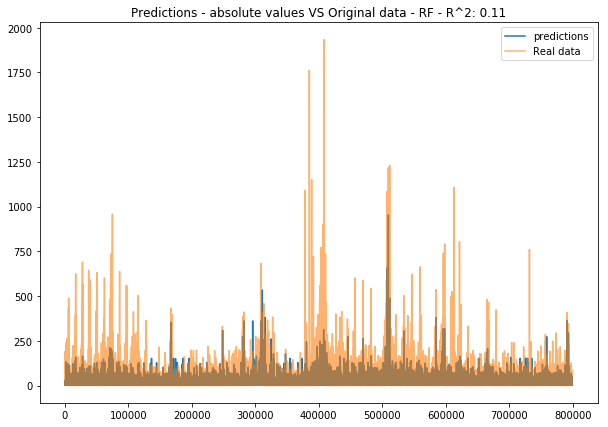

In [ ]:
# Comparaison - predictions & label
plt.figure(figsize=(10, 7))
plt.plot(best_pred_, label='predictions')
plt.plot(real_, label='Real data', alpha=0.6)
plt.title('Predictions - absolute values VS Original data - RF - R^2: ' + str(np.round(r2[best_], 2)))
plt.legend()
plt.show()

In [ ]:
# Verification
print('Original dataset:')
print('----')
print('Max unit sales:')
original = np.array(data_y.loc[test_set])
print(original.max())
print('Min unit sales:')
print(original.min())
print('Moyenne unit sales:')
print(original.mean())
print()

print('Original dataset - Rescaled:')
print('----')
print('Max unit sales:')
print(real_.max())
print('Min unit sales:')
print(real_.min())
print('Moyenne unit sales:')
print(real_.mean())
print()

print('Predictions:')
print('----')
print('Max unit sales:')
print(best_pred_.max())
print('Min unit sales:')
print(best_pred_.min())
print('Moyenne unit sales:')
print(best_pred_.mean())
print()

Original dataset:
----
Max unit sales:
1933.0
Min unit sales:
0.0
Moyenne unit sales:
5.476894

Original dataset - Rescaled:
----
Max unit sales:
1933.0
Min unit sales:
0.0
Moyenne unit sales:
5.476894

Predictions:
----
Max unit sales:
953.0223086384807
Min unit sales:
1.6512005271839176
Moyenne unit sales:
6.120697458600166



## V - XGBoost regressor

In [ ]:
# Estimation du meilleur hyper parametre
def GridSearchXGB(max_depth_, min_child_weight_, X_train=X_train, y_train=y_train, X_test=X_test):
    #### Code using Sk learn Wrapper for XGBoost
    xgb_model = XGBRegressor(learning_rate =.1, num_boost_round=500,
                             max_depth=max_depth_, min_child_weight=min_child_weight_,
                             gamma=0,  subsample=.8, colsample_bytree=.7, reg_alpha=1, 
                             objective= 'reg:linear')
    xgb_model.fit(X_train, y_train)
    y_hat = xgb_model.predict(X_test)

    pred = denormalize(data_y, y_hat)
    real = denormalize(data_y, y_test)
    # Score - R^2 (coefficient of determination) regression score function
    r2 = r2_score(real, pred)
    
    # Rescale the prediction between 0 and 1 - Under scaled predictions
    scaler_pred = MinMaxScaler(feature_range=(0, 1))
    scaler_fitted_pred = scaler_pred.fit(np.abs(y_hat).reshape(-1, 1))
    y_hat_scaled = scaler_fitted_pred.transform(np.abs(y_hat).reshape(-1, 1)).reshape(len(y_hat), )
    pred_rescaled = denormalize(data_y, y_hat_scaled)
    r2_rescaled = r2_score(real, pred_rescaled)
    
    return r2, r2_rescaled, pred, pred_rescaled, real

#### Hyperparameter estimation

In [ ]:
max_depth_ = np.arange(2, 5, 1)
min_child_weight_ = np.arange(2, 5, 1)

In [ ]:
print('Total grid search:', len(max_depth_)*len(min_child_weight_), 'iteration(s)')
print(max_depth_)
print(min_child_weight_)

Total grid search: 9 iteration(s)
[2 3 4]
[2 3 4]


In [ ]:
best_param = [] 
r2 = []
r2_rescaled = []
pred = []
pred_rescaled = []
val_loss = []
train_loss = []
real = []
j = 0

start = time.time()

for max_depth, min_child_weight in tqdm(itertools.product(max_depth_, min_child_weight_)):
    start_sub = time.time()
    r2_, r2_rescaled_, pred_, pred_rescaled_, real_ = GridSearchXGB(max_depth, min_child_weight)
    r2.append(r2_)
    r2_rescaled.append(r2_rescaled_)
    pred.append(pred_)
    pred_rescaled.append(pred_rescaled_)
    real.append(real_)
    best_param.append(max_depth)
    j += 1
    print('----')
    print('Iteration:', j)
    print('Executed in:', round((time.time()-start_sub)/60, 2), 'min')
    print('R2:', r2_)
    print('R2 rescaled predictions:', r2_rescaled_)
    print()
print('Execution time:', round((time.time()-start)/60, 2), 'min')

1it [03:22, 202.25s/it]

----
Iteration: 1
Executed in: 3.37 min
R2: 0.06530789053379604
R2 rescaled predictions: -294.2627740090286



2it [06:39, 200.74s/it]

----
Iteration: 2
Executed in: 3.29 min
R2: 0.060429047262116176
R2 rescaled predictions: -276.4262321287743



3it [09:53, 198.66s/it]

----
Iteration: 3
Executed in: 3.23 min
R2: 0.060433265317566875
R2 rescaled predictions: -276.41631844593803



#### Best model

In [ ]:
best_ = np.argsort(r2)[-1]
best_param_ = best_param[best_]
best_pred_ = pred[best_]
best_pred_rescaled_ = pred_rescaled[best_]
real_ = real[best_]

print('Best param:', best_param_)
print('RMSE:', r2[best_])
print('RMSE rescaled predictions:', r2_rescaled[best_])

In [ ]:
# Comparaison - predictions & label
plt.figure(figsize=(10, 7))
plt.plot(best_pred_, label='predictions')
plt.plot(real_, label='Real data', alpha=0.6)
plt.title('Predictions - absolute values VS Original data - XGB - R^2: ' + str(np.round(r2[best_], 2)))
plt.legend()
plt.show()

In [ ]:
# Verification
print('Original dataset:')
print('----')
print('Max unit sales:')
original = np.array(data_y.loc[test_set])
print(original.max())
print('Min unit sales:')
print(original.min())
print('Moyenne unit sales:')
print(original.mean())
print()

print('Original dataset - Rescaled:')
print('----')
print('Max unit sales:')
print(real_.max())
print('Min unit sales:')
print(real_.min())
print('Moyenne unit sales:')
print(real_.mean())
print()

print('Predictions:')
print('----')
print('Max unit sales:')
print(best_pred_.max())
print('Min unit sales:')
print(best_pred_.min())
print('Moyenne unit sales:')
print(best_pred_.mean())
print()

## VI - Recurrent neural network

### A - Model initialization

#### Input data

In [ ]:
# Dataset reshaped
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print('Train:')
print('----')
print(X_train.shape, y_train.shape)
print()
print('Valid:')
print('----')
print(X_valid.shape, y_valid.shape)
print()
print('Test:')
print('----')
print(X_test.shape, y_test.shape)

#### Graph definition - Hyperparameters research

In [ ]:
def GridSearchRNN(window_size, nb_epoch, batch_size, X_train=X_train, y_train=y_train,
                  X_test=X_test, y_test=y_test):

    # design network
    model = Sequential()
    model.add(LSTM(window_size, input_shape=(X_train.shape[1], X_train.shape[2]))) # compute window size
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # fit network
    history = model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,
                        validation_data=(X_valid, y_valid), verbose=0, shuffle=False)
    
    # make a prediction
    yhat = np.abs(model.predict(X_test))

    # invert scaling for forecast & original
    pred = denormalize(data_y, yhat)
    real = denormalize(data_y, y_test)
    r2 = r2_score(real, pred)
    
    # Rescale the prediction between 0 and 1 - Under scaled predictions
    scaler_pred = MinMaxScaler(feature_range=(0,1))
    scaler_fitted_pred = scaler_pred.fit(yhat)
    yhat_scaled = scaler_fitted_pred.transform(yhat)
    pred_rescaled = denormalize(data_y, yhat_scaled)
    r2_rescaled = r2_score(real, pred_rescaled)
    
    return r2, r2_rescaled, pred, pred_rescaled, real, history

#### Hyperparameters initialisation

In [ ]:
window_size = [5, 50, 500]
nb_epoch = [5]
batch_size = [250]

print('Total grid search:', len(window_size)*len(nb_epoch)*len(batch_size), 'iteration(s)')
print(window_size)
print(nb_epoch)
print(batch_size)

In [ ]:
best_param = [] 
r2 = []
r2_rescaled = []
pred = []
pred_rescaled = []
val_loss = []
train_loss = []
real = []
j = 0

start = time.time()

for size, epoch, batch in tqdm(itertools.product(window_size, nb_epoch, batch_size)):
    start_sub = time.time()
    r2_, r2_rescaled_, pred_, pred_rescaled_, real_, history = GridSearchRNN(size, epoch, batch)
    r2.append(r2_)
    r2_rescaled.append(r2_rescaled_)
    pred.append(pred_)
    pred_rescaled.append(pred_rescaled_)
    real.append(real_)
    best_param.append((size, epoch, batch))
    val_loss.append(history.history['val_loss'])
    train_loss.append(history.history['loss'])
    j += 1
    print('----')
    print('Iteration:', j)
    print('Executed in:', round((time.time()-start_sub)/60, 2), 'min')
    print('R2:', r2_)
    print('R2 rescaled predictions:', r2_rescaled_)
    print()

print('Execution time:', round((time.time()-start)/60, 2), 'min')

#### Best model

In [ ]:
best_ = np.argsort(r2)[-1]
best_param_ = best_param[best_]
best_pred_ = pred[best_]
best_pred_rescaled_ = pred_rescaled[best_]
real_ = real[best_]
val_loss_ = val_loss[best_]
loss_ = train_loss[best_]

print('Best param:', best_param_)
print('RMSE:', r2[best_])
print('RMSE rescaled predictions:', r2_rescaled[best_])

### C - Visualization

#### Cost of the prediction

In [ ]:
# plot history
plt.plot(loss_, label='train')
plt.plot(val_loss_, label='test')
plt.title('Evolution of the loss through epoch')
plt.xlabel("nombre d'epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

#### Predictions against original values

In [ ]:
# Comparaison - Non-scaled data
plt.figure(figsize=(10, 7))
plt.plot(best_pred_, label='predictions')
plt.plot(real_, label='Real data', alpha=0.6)
plt.title('Predictions - absolute values VS Original data')
plt.legend()
plt.show()

In [ ]:
# Comparaison - yhat rescaled between 0 and 1 after prediction
plt.figure(figsize=(10, 7))
plt.plot(best_pred_rescaled_, label='predictions')
plt.plot(real_, label='Real data', alpha=0.6)
plt.title('Predictions - absolute values VS Original data - rescaled')
plt.legend()
plt.show()

In [ ]:
# Verification
print('Original dataset:')
print('----')
print('Max unit sales:')
original = np.array(data_y.loc[test_set])
print(original.max())
print('Min unit sales:')
print(original.min())
print('Moyenne unit sales:')
print(original.mean())
print()

print('Original dataset - Rescaled:')
print('----')
print('Max unit sales:')
print(real_.max())
print('Min unit sales:')
print(real_.min())
print('Moyenne unit sales:')
print(real_.mean())
print()

print('Predictions:')
print('----')
print('Max unit sales:')
print(best_pred_.max())
print('Min unit sales:')
print(best_pred_.min())
print('Moyenne unit sales:')
print(best_pred_.mean())
print()